In [2]:
import pandas as pd

In [30]:
# EMTAB37=pd.read_table("EMTAB37rma.csv", sep='\t').set_index('Unnamed: 0',drop=True)
# probes=pd.read_table("EMTAB37probes.csv", sep=',')
# probes=probes.dropna(subset=['SYMBOL'])
# EMTAB37_gene=pd.merge(EMTAB37,probes, how='inner', left_index=True, right_on='PROBEID').set_index('SYMBOL',drop=True)
# EMTAB37_gene=EMTAB37_gene.T.rename_axis(None).drop(['PROBEID','GENENAME'])
# EMTAB37_sdrf=pd.read_table("EMTAB37.sdrf.txt", sep='\t')
# EMTAB37_sdrf=EMTAB37_sdrf[['Factor Value[CELLLINE]','Array Data File']]  
# EMTAB37_gene=pd.merge(EMTAB37_gene,EMTAB37_sdrf,left_index=True, right_on='Array Data File').set_index('Factor Value[CELLLINE]',drop=True)


In [32]:
# import eurofins drug sensitivity data filter to contain only erlotinib fit with sigmoid
# the actarea for other cells was calculated with constant or linear and skews the data towards non-respondents
# 211 cell lines selected of which 120 have active area < 1
sensitivity=pd.read_table("NIHMS361223-drug-sensitivity.csv", sep=",")
erlotinib_sig = sensitivity[sensitivity['Compound']=='Erlotinib'][sensitivity['FitType']=='Sigmoid']
erlotinib_sig['CCLE_clean'] = [w.split('_',1)[0] for w in erlotinib_sig['﻿CCLE Cell Line Name']]
erlotinib = erlotinib_sig[['CCLE_clean', 'ActArea']]


/Users/wh_admin/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [9]:
# import test data from BATTLE lung cancer drug trials
# EGEOD-31437rma.csv constains the rma normalized probe intensities using affy package
# hugene10.csv containst the mapping between probes and genes
# E-GEOD-31437.sdrf.txt contains the mapping between samples and cell names
battle_test=pd.read_csv("EGEOD-31437rma.csv").set_index("Probe",drop=True)
hugogene10=pd.read_table("hugene10.csv", sep=',').dropna(subset=['Symbol'])
battle_test_gene=pd.merge(battle_test,hugogene10, how='inner', left_index=True, right_on='ID').set_index('Symbol',drop=True)
battle_test_gene=battle_test_gene.T.rename_axis(None).drop(['Unnamed: 0','ID','Entrez', 'Name'])
battle_test_gene=battle_test_gene.loc[:,~battle_test_gene.columns.duplicated()]
battle_test_sdrf=pd.read_table("E-GEOD-31437.sdrf.txt", sep='\t')
battle_test_sdrf=battle_test_sdrf.set_index(battle_test_sdrf["Array Data File"].replace('.CEL','',regex=True),drop=True)
battle_test_gene=pd.merge(battle_test_gene,battle_test_sdrf,left_index=True, right_index=True)
battle_test_gene.shape

(131, 19200)

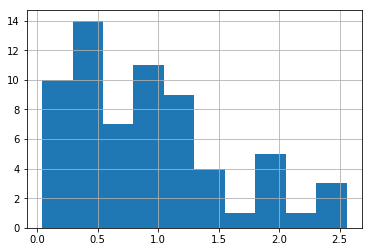

In [59]:

# merge expression and erlotinib
# EMTAB37_gene_inter=pd.merge(EMTAB37_gene,erlotinib, how='inner', left_index=True, right_on='CCLE_clean').drop_duplicates(subset='CCLE_clean').set_index('CCLE_clean',drop=True)
# compressed and saved intermediate result as raw file could not be uploaded
# EMTAB37_gene_inter.to_csv("EMTAB37_inter.csv")

EMTAB37_gene_inter = pd.read_csv("EMTAB37_inter.csv", index_col=0)
EMTAB37_gene_training = EMTAB37_gene_inter.iloc[:,:-14]
EMTAB37_target = EMTAB37_gene_inter['ActArea']

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax =plt.subplots()
EMTAB37_target.hist(ax=ax, bins=10)
plt.show()

In [60]:
from sklearn.feature_selection import SelectPercentile, f_regression
selector = SelectPercentile(f_regression, percentile=10)
selector.fit(EMTAB37_gene_training,EMTAB37_target)
high_corr_EMTAB37=EMTAB37_gene_training.iloc[:,selector.pvalues_<0.001]
high_corr_EMTAB37.shape

(65, 175)

In [66]:
# in the papaer a binary classifier was used with arbitrary thresholds
# ideally use regression to predict a continuous ActArea and then calculate R2 between act area and PFS
# reduce feature using SelectFromModel using ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold

model = ElasticNetCV(cv=KFold(n_splits=5, shuffle=True, random_state=0),random_state=0, max_iter=2000)
params = SelectFromModel(model).fit(high_corr_EMTAB37,EMTAB37_target)
selected_EMTAB37 = pd.DataFrame(params.transform(high_corr_EMTAB37),columns=high_corr_EMTAB37.columns[params.get_support()])
selected_EMTAB37.columns
selected_EMTAB37=selected_EMTAB37.loc[:,~selected_EMTAB37.columns.duplicated()]
selected_EMTAB37= selected_EMTAB37[selected_EMTAB37.columns & battle_test_gene.columns]


In [67]:
regr = ElasticNetCV(cv=KFold(n_splits=4, shuffle=True), random_state=1, max_iter=2500)
regr.fit(selected_EMTAB37,EMTAB37_target)
regr.score(selected_EMTAB37,EMTAB37_target)

0.7203820316425775

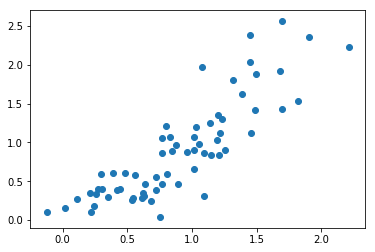

In [68]:
fig, ax =plt.subplots()
plt.scatter(regr.predict(selected_EMTAB37),EMTAB37_target)

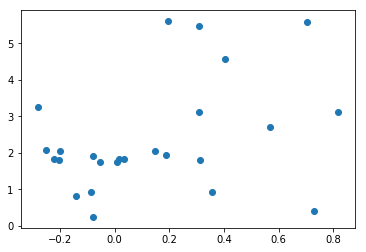

In [69]:
battle_test_selected=battle_test_gene[list(selected_EMTAB37.columns)][battle_test_gene['FactorValue [TREATMENT]']=='erlotinib']
survival=battle_test_gene[battle_test_gene['FactorValue [TREATMENT]']=='erlotinib']['FactorValue [PROGRESSION-FREE SURVIVAL TIME (MONTHS)]']
fig, ax =plt.subplots()
plt.scatter(regr.predict(battle_test_selected),survival.astype('float'))